# Convolutional Neural Network

## Forward
---
- Zero Paddings
- Convolutional Layer
- Pooling
- Combination: Conv + Pool

Zero Padding pads 0s at the edge of an image, benefits include:
- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

<img src="images/PAD.png" style="width:600px;height:400px;">

<caption><center>from Deep Learning Specilization Course</center></caption>

Consider an input of batched images with shape:

$$(m, n_W, n_H, n_C)$$

Where $m$ is the batch size, $n_W$ is the width of the image, $n_H$ is the height and $n_C$ is number of channels -- RGB would has 3 channels.

After padded with size $p$, the size would become

$$(m, n_W + 2p, n_H + 2p, n_C)$$

In [25]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [26]:
def zero_pads(X, pad):
    """
    X has shape (m, n_W, n_H, n_C)
    """
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    return X_pad

X shape (3, 4, 4, 3)
X_pad shape (3, 8, 8, 3)


Text(0.5, 1.0, 'paded')

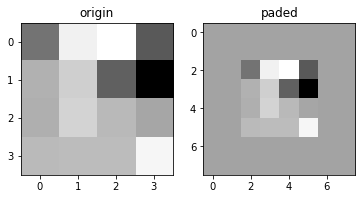

In [33]:
X = np.random.randn(3, 4, 4, 3)
X_pad = zero_pads(X, 2)

print('X shape', X.shape)
print('X_pad shape', X_pad.shape)

plt.subplot(1, 2, 1)
plt.imshow(X[0, :, :, 1], cmap='gray')
plt.title('origin')

plt.subplot(1, 2, 2)
plt.imshow(X_pad[0, :, :, 1], cmap='gray')
plt.title('paded')

## One Step of Convolutional Layer
---
<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">

Consider a filter mapped to one piece of the image, with 

$$ \text{filter size:} \quad (f, f, n_C) $$
$$ \text{piece of image} \quad (f, f, n_C) $$

Where filter has the deepth of the piece of input image.

Another way to look at this is you can think of the filter as the weights $W$, and for each piece of the image, it serve as an input $X$, so in the convolutional process, the formula equals:

$$ Z = sum(W*X) + b $$
$$ A = g(Z) $$

Where $b$ is the bias and $g$ is the activation function. Doesn't it look very similar to the equations in the dense neural network?

In [36]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


def one_step_conv(X, W, b):
    """
    X is the input, and W is the filter, both have the size (f, f, n_C)
    b is the bias for this specific filter (note that different filters don't share the same bias)
    Here suppose that we all take sigmoid as the activation function
    """
    assert X.shape == W.shape
    Z = np.sum(np.multiply(W, X)) + b
    A = sigmoid(Z)
    return A

In [38]:
X = np.random.randn(10, 10, 3)
W = np.random.randn(10, 10, 3)
b = 0

A = one_step_conv(X, W, b)
print(A)

0.003152880008032791


## Convolution
---
<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

Now the input (here we use `A_prev` ) would be a batch of whole images with size 

$$ (m, n_{W_{prev}}, n_{H_{prev}}, n_{C_{prev}}) $$

Filter with size

$$ (n_{C}, f, f, n_{C_{prev}}) $$

Where $n_{C}$ is the number of filters, which would become the depth of the output image.

Bias with size

$$ (n_{C}, 1) $$

And parameters include:
$$ \text{padding of each image:} \enspace pad $$

$$ \text{moving step:} \enspace stride $$

So the resulting output would have size:

$$ (m, \lfloor\frac{n_{W_{prev}} + 2p - f}{stride}\rfloor  + 1, \lfloor\frac{n_{H_{prev}} + 2p - f}{stride}\rfloor  + 1, n_C)$$

Now given a image from the input, we will need to slice it into pieces and multiply with the filter one by one. 

Consider a 2D image with size $(n_{W_{prev}}, n_{H_{prev}})$, and stride is $s$, filter size if $f$, then the top-left corner of the output image would have mapping:
```python
input[0:(0 + f), 0:(0 + f)] -> output[0, 0]
```

And
```python
input[s:(s + f), 0:(0 + f)] -> output[1, 0]
```

The pattern would be:
```python
input[i*s:(i*s + f), j*s:(j*s + f)] -> output[i, j]
```

We will make use of this pattern in our implementation of slice the origin image and map to the output.

In [62]:
def conv(A_prev, filters, bias, parameters):
    """
    A_prev: the input of batched images with shape: (m, n_W_prev, n_H_prev, n_C_prev)
    filters has shape: (n_C, f, f, n_C_prev)
    """
    
    m, n_W_prev, n_H_prev, n_C_prev = A_prev.shape
    pad, stride = parameters['pad'], parameters['stride']
    n_C, f, f, _ = filters.shape
    
    n_W = (n_W_prev + 2*pad - f) // stride + 1
    n_H = (n_H_prev + 2*pad - f) // stride + 1
    
    output = np.zeros((m, n_W, n_H, n_C))
    padded_A_prev = zero_pads(A_prev, pad)
    
    for i in range(m):
        # take out the image
        padded_img = padded_A_prev[i]
        for c in range(n_C):
            # take out filters and bias for the channel
            fil = filters[c]
            b = bias[c]
            for w in range(n_W):
                for h in range(n_H):
                    w_range = (stride*w, stride*w + f)
                    h_range = (stride*h, stride*h + f)
                    img_slice = padded_img[w_range[0]:w_range[1], h_range[0]:h_range[1], :]
                    output[i, w, h, c] = one_step_conv(img_slice, fil, b)
    
    return output

In [68]:
A_prev = np.random.randn(4, 28, 28, 3)
filters = np.random.randn(10, 3, 3, 3)  # filter size (3, 3, 3)
bias = np.zeros(10)
parameters = {'pad': 2, 'stride': 2}

Z = conv(A_prev, filters, bias, parameters)
print(Z.shape)

(4, 15, 15, 10)


# Pooling
---
After convolutional layer, it typically follows a pooling layer. The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

<caption><center>from Deep Learning Specilization Course</center></caption>

The process is pretty much the same as the convolutional layer, with a filter and a stride, at each step, we will take a slice of the whole image and compute one value -- either max or average -- from it.

Given filter size $f$, stride $s$ and input size:
$$ (m, n_{W_{prev}}, n_{H_{prev}}, n_{C_{prev}}) $$

Output would have size:

$$ (m, \lfloor\frac{n_{W_{prev}} - f}{stride}\rfloor  + 1, \lfloor\frac{n_{H_{prev}} - f}{stride}\rfloor  + 1, n_C)$$
$$ n_C = n_{C_{prev}}$$

In [66]:
def pooling(A_prev, parameters, mode='max'):
    """
    A_prev: the input of batched images with shape: (m, n_W_prev, n_H_prev, n_C_prev)
    """
    m, n_W_prev, n_H_prev, n_C_prev = A_prev.shape
    f, stride = parameters['f'], parameters['stride']
    
    n_W = (n_W_prev - f)//stride + 1
    n_H = (n_H_prev - f)//stride + 1
    n_C = n_C_prev
    
    output = np.zeros((m, n_W, n_H, n_C))
    for i in range(m):
        img = A_prev[i]
        for w in range(n_W):
            for h in range(n_H):
                for c in range(n_C):
                    w_range = (stride*w, stride*w + f)
                    h_range = (stride*h, stride*h + f)
                    img_slice = img[w_range[0]:w_range[1], h_range[0]:h_range[1], c]
                    if mode == 'max':
                        output[i, w, h, c] = np.max(img_slice)
                    elif mode == 'average':
                        output[i, w, h, c] = np.mean(img_slice)
    return output

In [70]:
A_prev = np.random.randn(4, 28, 28, 3)
parameters = {'f': 2, 'stride': 2}

A = pooling(A_prev, parameters, mode='max')
print(A.shape)

(4, 14, 14, 3)
